# **Image Colorization With GANs**

Generative Adversarial Networks (GANs) are cutting-edge machine learning models capable of creating new data instances that closely resemble existing ones. Inspired by game theory, GANs employ an adversarial process to generate highly realistic samples.

In this project, we'll demonstrate the power of GANs by applying them to colorize grayscale images. Our generator model will adopt a UNet-like architecture, incorporating skip connections for enhanced performance.

Get ready to dive into the code and witness the fascinating capabilities of GANs!

## 1. Downloading the Dataset

**We'll any color photo sets for GAN model. Fortunately, here we use train_color directory in liested Kaggle dataset!**

**Download the dataset:**

* Visit the following link and download the dataset: [Kaggle Image Colorization Dataset](https://www.kaggle.com/datasets/aayush9753/image-colorization-dataset)

**Alternatively, uncomment the following lines if you have Kaggle API access:**

    !kaggle datasets download aayush9753/image-colorization-dataset
    
    !unzip /content/image-colorization-dataset.zip

**Once you have the dataset downloaded, run the following cell to unzip it (if necessary).**

In [3]:
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import os
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
from tensorflow.python.keras.callbacks import ModelCheckpoint

2024-09-23 17:54:41.687399: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


To prepare our data, we'll process each RGB image individually, converting it to grayscale using PIL's .convert('L') method. This will create pairs of (grayscale image, RGB image) for our dataset.

We've limited our dataset size to dataset_split due to Colab's computational constraints. This ensures efficient training and prevents resource exhaustion."

In [4]:
batch_size = 5
img_size = 120
dataset_split = 1800

master_dir = "../data/train_color"
x = []
y = []
for image_file in os.listdir(master_dir)[0: dataset_split]:
    rgb_image = Image.open(os.path.join(master_dir, image_file)).resize((img_size, img_size))
    # Normalize the RGB image array
    rgb_image_array = (np.asarray(rgb_image)) / 255
    grey_image = rgb_image.convert('L')
    # Normalize the Grey scale image array
    grey_image_array = (np.asarray(grey_image).reshape((img_size, img_size, 1))) / 255
    x.append(grey_image_array)
    y.append(rgb_image_array)

# train test splitting
train_x, test_x, train_y, test_y = train_test_split(np.array(x), np.array(y), test_size=0.1)

# Construct tf.data.Dataset object
dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
dataset = dataset.batch(batch_size)

In [5]:
print(train_x.shape,train_y.shape)
print(test_x.shape,test_y.shape)

(1620, 120, 120, 1) (1620, 120, 120, 3)
(180, 120, 120, 1) (180, 120, 120, 3)


Text(0.5, 1.0, 'Ground True RGB')

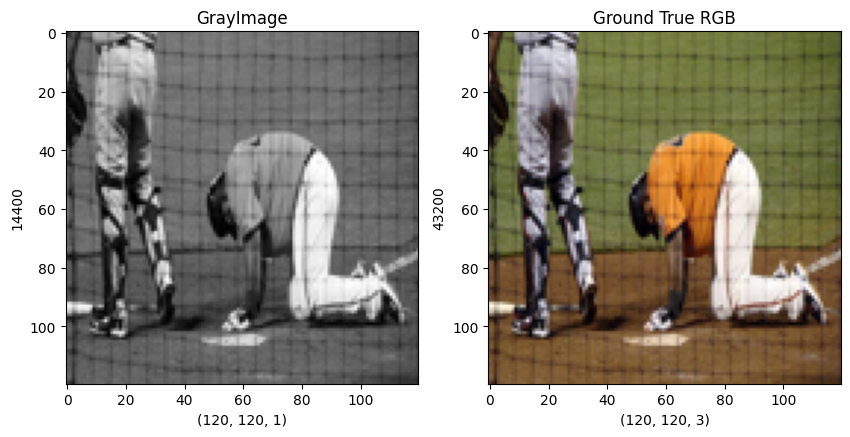

In [6]:
figure,axis = plt.subplots(1,2,figsize=(10,10))
img_number = 3

gray_img = train_x[img_number]
rgb_img = train_y[img_number]

# Convert gray image to a format that can be displayed
gray_img_display = gray_img.reshape(gray_img.shape[0], gray_img.shape[1])
axis[0].imshow(gray_img_display, cmap='gray')
axis[0].set_xlabel(gray_img.shape)
axis[0].set_ylabel(gray_img.size)
axis[0].set_title("GrayImage")
axis[1].imshow(rgb_img)
axis[1].set_xlabel(rgb_img.shape)
axis[1].set_ylabel(rgb_img.size)
axis[1].set_title("Ground True RGB")

Text(0.5, 1.0, 'Ground True RGB')

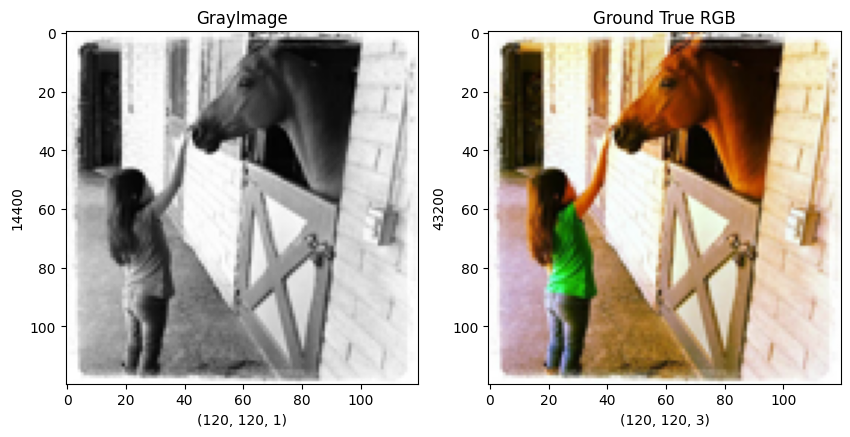

In [18]:
figure,axis = plt.subplots(1,2,figsize=(10,10))
img_number = 3

gray_img = test_x[img_number]
rgb_img = test_y[img_number]

axis[0].imshow(gray_img, cmap="gray")
axis[0].set_xlabel(gray_img.shape)
axis[0].set_ylabel(gray_img.size)
axis[0].set_title("GrayImage")
axis[1].imshow(rgb_img)
axis[1].set_xlabel(rgb_img.shape)
axis[1].set_ylabel(rgb_img.size)
axis[1].set_title("Ground True RGB")

## 2. Building the GAN

Let's construct our GAN model using Keras. We'll start by defining the generator, followed by the discriminator, and then the loss functions for each.

In [19]:

def get_generator_model(img_size):
    inputs = tf.keras.layers.Input(shape=(img_size, img_size, 1))

    conv1 = tf.keras.layers.Conv2D(16, kernel_size=(5, 5), strides=1)(inputs)
    conv1 = tf.keras.layers.LeakyReLU()(conv1)
    conv1 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=1)(conv1)
    conv1 = tf.keras.layers.LeakyReLU()(conv1)
    conv1 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=1)(conv1)
    conv1 = tf.keras.layers.LeakyReLU()(conv1)

    conv2 = tf.keras.layers.Conv2D(32, kernel_size=(5, 5), strides=1)(conv1)
    conv2 = tf.keras.layers.LeakyReLU()(conv2)
    conv2 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=1)(conv2)
    conv2 = tf.keras.layers.LeakyReLU()(conv2)
    conv2 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=1)(conv2)
    conv2 = tf.keras.layers.LeakyReLU()(conv2)

    conv3 = tf.keras.layers.Conv2D(64, kernel_size=(5, 5), strides=1)(conv2)
    conv3 = tf.keras.layers.LeakyReLU()(conv3)
    conv3 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), strides=1)(conv3)
    conv3 = tf.keras.layers.LeakyReLU()(conv3)
    conv3 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), strides=1)(conv3)
    conv3 = tf.keras.layers.LeakyReLU()(conv3)

    bottleneck = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), strides=1, activation='tanh', padding='same')(conv3)

    concat1 = tf.keras.layers.Concatenate()([bottleneck, conv3])
    conv_up_3 = tf.keras.layers.Conv2DTranspose(128, kernel_size=(3, 3), strides=1, activation='relu')(concat1)
    conv_up_3 = tf.keras.layers.Conv2DTranspose(128, kernel_size=(3, 3), strides=1, activation='relu')(conv_up_3)
    conv_up_3 = tf.keras.layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=1, activation='relu')(conv_up_3)

    concat2 = tf.keras.layers.Concatenate()([conv_up_3, conv2])
    conv_up_2 = tf.keras.layers.Conv2DTranspose(64, kernel_size=(3, 3), strides=1, activation='relu')(concat2)
    conv_up_2 = tf.keras.layers.Conv2DTranspose(64, kernel_size=(3, 3), strides=1, activation='relu')(conv_up_2)
    conv_up_2 = tf.keras.layers.Conv2DTranspose(32, kernel_size=(5, 5), strides=1, activation='relu')(conv_up_2)

    concat3 = tf.keras.layers.Concatenate()([conv_up_2, conv1])
    conv_up_1 = tf.keras.layers.Conv2DTranspose(32, kernel_size=(3, 3), strides=1, activation='relu')(concat3)
    conv_up_1 = tf.keras.layers.Conv2DTranspose(32, kernel_size=(3, 3), strides=1, activation='relu')(conv_up_1)
    conv_up_1 = tf.keras.layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=1, activation='relu')(conv_up_1)

    model = tf.keras.models.Model(inputs, conv_up_1)
    return model

 
 ### **2.2 Discriminator**

In [20]:
def get_discriminator_model():
    layers = [
        tf.keras.layers.Conv2D(32, kernel_size=(7, 7), strides=1, activation='relu', input_shape=(120, 120, 3)),
        tf.keras.layers.Conv2D(32, kernel_size=(7, 7), strides=1, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, kernel_size=(5, 5), strides=1, activation='relu'),
        tf.keras.layers.Conv2D(64, kernel_size=(5, 5), strides=1, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(128, kernel_size=(3, 3), strides=1, activation='relu'),
        tf.keras.layers.Conv2D(128, kernel_size=(3, 3), strides=1, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(256, kernel_size=(3, 3), strides=1, activation='relu'),
        tf.keras.layers.Conv2D(256, kernel_size=(3, 3), strides=1, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ]
    model = tf.keras.models.Sequential(layers)

    return model

### **2.3 Loss Functions**

In [21]:
# Loss function
cross_entropy = BinaryCrossentropy()
mse = MeanSquaredError()


def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output) - tf.random.uniform(shape=real_output.shape, maxval=0.1),
                              real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output) + tf.random.uniform(shape=fake_output.shape, maxval=0.1),
                              fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


def generator_loss(fake_output, real_y):
    real_y = tf.cast(real_y, 'float32')
    return mse(fake_output, real_y)


generator_optimizer = tf.keras.optimizers.Adam(0.0005)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0005)

generator = get_generator_model(img_size)
discriminator = get_discriminator_model()


@tf.function
def train_step(input_x, real_y):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate an image -> G(x)
        generated_images = generator(input_x, training=True)
        # Probability that the given image is real -> D( x )
        real_output = discriminator(real_y, training=True)
        # Probability that the given image is the one generated -> D( G( x ) )
        generated_output = discriminator(generated_images, training=True)

        # L2 Loss -> ||y-G(x)||^2
        gen_loss = generator_loss(generated_images, real_y)
        # Log loss for the discriminator
        disc_loss = discriminator_loss(real_output, generated_output)

        # Compute the gradients
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        # Optimize with Adam
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

/Users/huaduojiejia/MyProject/dev/hslu/CV/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Running the training loop

In [ ]:
num_epochs = 200
for e in range(num_epochs):
    for (x_component, y_component) in dataset:
        # Here ( x , y ) represents a batch from our training dataset.
        print("(epoch no: ", e, ") ", x_component.shape, " ", y_component.shape)
        train_step(x_component, y_component)

Load the model

In [25]:
generator_model = tf.keras.models.load_model('models/generator_Model.h5')
generator_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 120, 120,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 116, 116,  │        416 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 116, 116,  │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 114, 114,  │      4,640 │ leaky_re_lu[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 114, 114,  │          0 │ conv2d_1[0][0]    │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │      9,248 │ leaky_re_lu_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 112, 112,  │          0 │ conv2d_2[0][0]    │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 108, 108,  │     25,632 │ leaky_re_lu_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 108, 108,  │          0 │ conv2d_3[0][0]    │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 106, 106,  │     18,496 │ leaky_re_lu_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 106, 106,  │          0 │ conv2d_4[0][0]    │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 104, 104,  │     36,928 │ leaky_re_lu_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_5       │ (None, 104, 104,  │          0 │ conv2d_5[0][0]    │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 100, 100,  │    102,464 │ leaky_re_lu_5[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_6       │ (None, 100, 100,  │          0 │ conv2d_6[0][0]    │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 98, 98,    │     73,856 │ leaky_re_lu_6[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_7       │ (None, 98, 98,    │          0 │ conv2d_7[0][0]  

 Total params: 1,406,403 (5.37 MB)

 Trainable params: 1,406,403 (5.37 MB)

 Non-trainable params: 0 (0.00 B)

## 3. Result

Let's construct our GAN model using Keras. We'll start by defining the generator, followed by the discriminator, and then the loss functions for each.

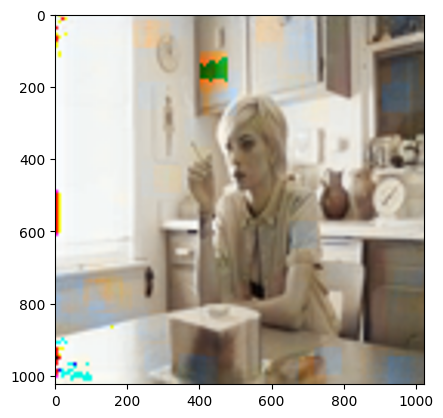

In [55]:
# lets predict 5 rgb colors
predicted_rgb = generator_model( test_x[ 0 : 5 ] ).numpy()
i = 4
image = Image.fromarray( ( predicted_rgb[i] * 255 ).astype( 'uint8' ) ).resize( ( 1024 , 1024 ) )
image = np.asarray( image )
plt.imshow( image)

Text(0.5, 1.0, 'Ground Truth RGB')

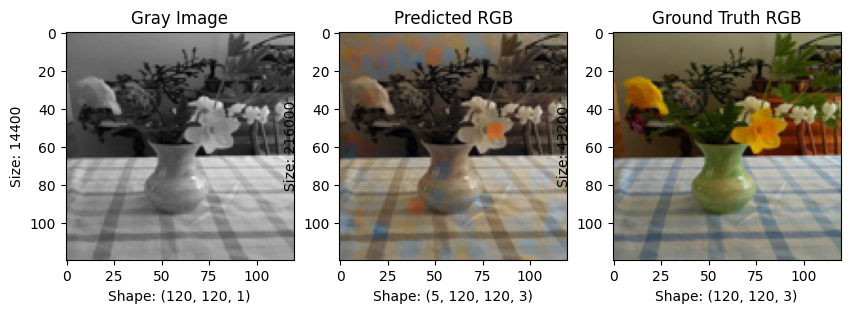

In [62]:
img_number = 2

figure, axis = plt.subplots(1, 3, figsize=(10, 10))

gray_img = test_x[img_number]
rgb_img = test_y[img_number]

axis[0].imshow(gray_img, cmap="gray")
axis[0].set_xlabel(f"Shape: {gray_img.shape}")
axis[0].set_ylabel(f"Size: {gray_img.size}")
axis[0].set_title("Gray Image")

axis[1].imshow(predicted_rgb[img_number])
axis[1].set_xlabel(f"Shape: {predicted_rgb.shape}")
axis[1].set_ylabel(f"Size: {predicted_rgb.size}")
axis[1].set_title("Predicted RGB")


axis[2].imshow(rgb_img)
axis[2].set_xlabel(f"Shape: {rgb_img.shape}")
axis[2].set_ylabel(f"Size: {rgb_img.size}")
axis[2].set_title("Ground Truth RGB")
